# Switching multi-armed bandit

The switching bandits are a variant of dynamic multi-armed bandits in which reward probability $p_{t, l}$ changes suddenly but is otherwise constant. Starting with the stationary model described in stationary_bandits_comparison.ipynb we will introduce reward probability changes as sudden switches in the arm associated with highest reward probability. 

At each time step the arm associated with the highest reward probability would either stay unchanged with probability $1-\rho$ or associated with another randomly selected arm with with probability $\rho$.

Here, we set the highest reward probability to $p_{max} = \epsilon + \frac{1}{2}$ and all other arms will be associated with $p=\frac{1}{2}$. This way three parameters define difficulty of inferring the best arm, $\epsilon$ the expected reward bonus, $\rho$ the transition probability, and $K$ the number of arms.

In [33]:
import numpyro as npyro
import numpyro.distributions as dist
import jax.numpy as jnp
from jax import random, lax, nn, ops
from collections import defaultdict

from opt_einsum import contract

import matplotlib.pyplot as plt
import seaborn as sns

from jupyterthemes import jtplot

sns.set(style="ticks", context='paper', color_codes=True)
jtplot.style(context='paper', fscale=1.6, ticks=True, grid=False)
plt.rcParams.update({
    'axes.spines.right': False, 
    'axes.spines.top': False, 
    'lines.linewidth': 2., 
    'axes.xmargin': 0.01, 
    'savefig.dpi': 300,
})

%matplotlib inline

def log(x):
    return jnp.nan_to_num(jnp.log(x))

def einsum(*args):
    return contract(*args, backend="jax")

In [4]:
def process(rng_key, t, choices, states, B=None, K=10, **kwargs):
    
    if B is not None:
        probs = B[states]
    else:
        probs = jnp.ones(K)/K
    
    N = len(choices)
    eps = kwargs['eps']
    
    rng_key, _rng_key = random.split(rng_key)
    new_states = random.categorical(_rng_key, log(probs))
    
    rng_key, _rng_key = random.split(rng_key)
    reward_probs = .5 + eps * jnp.eye(K)[states]
    outcomes = random.bernoulli(_rng_key, reward_probs, shape=(N, K))
    
    return outcomes, new_states

def simulator(process, params, seed, N=100, T=1000):
    def sim_fn(carry, t):
        rng_key, states, choices = carry
        rng_key, _rng_key = random.split(rng_key)
        
        outcomes, states = process( _rng_key, t, choices, states, **params)
        return (rng_key, states, choices), {'rewards': outcomes, 'states': states}
    
    rng_key = random.PRNGKey(seed)
    states = jnp.zeros(N, dtype=jnp.int32)
    choices = jnp.zeros(N, dtype=jnp.int32)
    
    _, sequence = lax.scan(sim_fn, (rng_key, states, choices), jnp.arange(T))
    
    I = jnp.eye(params['K'])    
    probs = .5 + params['eps'] * I[sequence['states']]
    probs0 = jnp.expand_dims(.5 + params['eps'] * I[states], 0)
    
    sequence['probs'] = jnp.concatenate([probs0, probs], 0)[:-1]
    
    return sequence

In [5]:
K = 3
eps = .25
rho = .01
seed = 12345

B = (1 - rho) * jnp.eye(K) + rho * (jnp.ones((K, K)) - jnp.eye(K))/(K-1)

params = {
    'K': K,
    'eps': eps,
    'B': B
}

sequence = simulator(process, params, seed, T=1000)

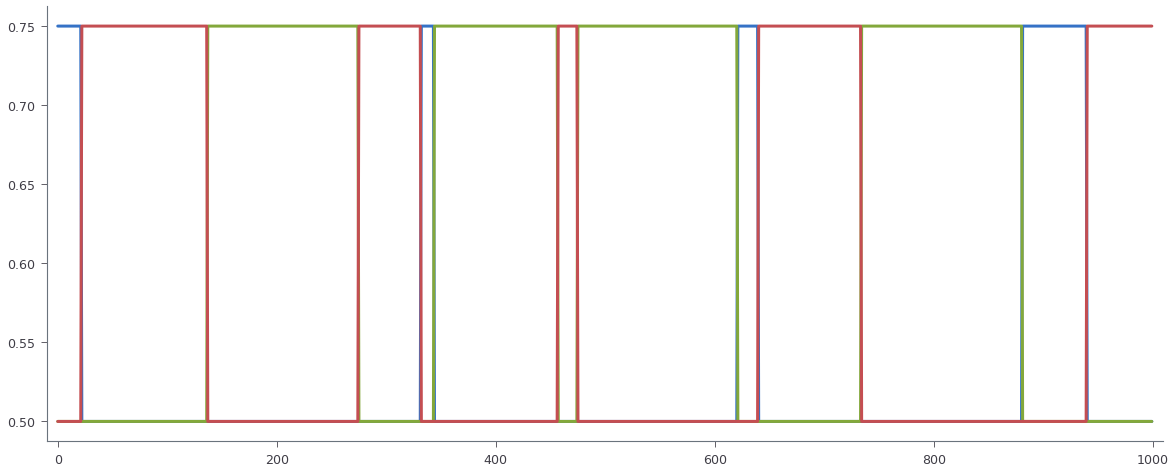

In [4]:
plt.figure(figsize=(20, 8))
plt.plot(sequence['probs'][:, 0], lw=3);

Lets assume that reward probability can have only D discrete values, for example 

$$ p \in P = \left\{\frac{1}{2D}, \ldots, 1-1/D\right\}$$

where $D$ denotes number of discrete values and $|P| = D$.

Hence if we associate reward probabilities of each arm with descrete hidden states $k_{t,l}$ we can describe the whole problem as a hierarchical hidden markov model. In this case the state transition matrix is given as 

$$ p(\vec{k}_{t,l}|\vec{k}_{t-1, l}, j_{t-1}=0) = \prod_{l=1}^K p(k_{t,l}|k_{t-1,l}, j_{t-1}=0) = \prod_{l=1}^K I_D$$

that is, states do not change in the absence of a change point, and

$$ p(\vec{k}_{t,l}|\vec{k}_{t-1, l}, j_{t-1}=1) = \prod_{l=1}^K p(k_{t,l}|k_{t-1,l}, j_{t-1}=1) = \prod_{l=1}^K \frac{1}{D-1} \left( J_{D} - I_D \right) $$

where $J_D$ stands for a D-dimensional matrix of ones, and $I_D$ for a D-dimensional identity matrix.

This way one can define an exact update of beliefs using Bayes rule

$$ p(\vec{k}_t, j_t|\vec{o}_{1:t}) \propto p(\vec{o}_t|\vec{k}_t)p(\vec{k}_t,j_t|\vec{o}_{1:t-1})$$

where 

$$ p(\vec{o}_t|\vec{k}_t) = \prod_{l=1}^K p(o_{t,l}|k_{t,l}) = \prod_{l=1}^K P(k_{t,l})^{o_{t,l}}\left( 1-P(k_{t,l}) \right)^{1-o_{t,l}}$$

The above observation likelihood would correspond to the case when the agent can sample outcomes from all arms at the same time. However, we are considering the case when on any trial only one arm can be sampled. We will associate a choice of an agent to sample from the $l$th arm at trial $t$ with as another random variable $s_t=l$, where

$$ p(s_t|s_{t-1}, a_t) = p(s_t|a_t) = \delta_{s_t, a_t}$$
where $a_t$ denotes a choice at trial $t$. Finally, sampling from the $l$th arm corresponds with observing an outcome $o_{t,l}$ with underlying probability $p_{t,l}$ and outcomes from all other arms with probability $1/2$, for all $m\neq l$. Hence, we can define the observation likelihood as 

$$ p(\vec{o}_t|\vec{k}_t, s_t=l) = P(k_{t,l})^{o_{t,l}}\left( 1-P(k_{t,l}) \right)^{1-o_{t,l}} \prod_{m \neq l} \frac{1}{2}^{1-o_{t,m} + o_{t,m}} $$

We will assume that the choice states $s_t$ are directly observable, hence

$$ p(o^s_t = o|s_t=l) = \delta_{o, l}$$

In [6]:
class Simulator(object):
    
    def __init__(self, process, learning, selection, params, N=10, T=1000, K=10):
        
        self.N = N  # number of parallel runs
        self.T = T  # number of trials
        self.K = K  # number of arms
        
        self.I = jnp.eye(K)
        
        self.process = process  # generative process
        self.learning = learning  # learning alogrithm 
        self.selection = selection  # action selection algorithm
        
        self.params = params  # parameters of the generative model and process
        
        rho = self.params['rho']
        B = (1 - rho) * jnp.eye(K) + rho * (jnp.ones((K, K)) - jnp.eye(K))/(K-1)
        self.params['B'] = B
        self.params['K'] = K
        
    def scan(self, func, carry, iterator):
        
        sequence = []
        for n in iterator:
            carry, res = func(carry, n)
            sequence.append(res)
        
        final = defaultdict(lambda: [])
        for seq in sequence:
            for key in seq.keys():
                final[key].append(seq[key])
        
        for key in final.keys():
            final[key] = jnp.stack(final[key], 0)
        
        return final
        
    def run(self, prior, seed=0):
        def sim_fn(carry, t):
            rng_key, states, prior = carry

            rng_key, _rng_key = random.split(rng_key)
            choices = self.selection(_rng_key, prior, t=t, **self.params)

            rng_key, _rng_key = random.split(rng_key)
            outcomes, states = self.process(_rng_key, t, choices, states, **self.params)
            
            prediction = self.learning(outcomes, choices, prior, **self.params)

            return (rng_key, states, prediction), {'outcomes': outcomes, 
                                                  'states': states,
                                                  'choices': choices,
                                                  'beliefs': prior}

        rng_key = random.PRNGKey(seed)
        states = jnp.zeros(1, dtype=jnp.int32)
        sequence = self.scan(sim_fn, (rng_key, states, prior), jnp.arange(self.T))
    
        probs = .5 + self.params['eps'] * self.I[sequence['states'][..., 0]]
        probs0 = .5 + self.params['eps'] * self.I[states]

        sequence['probs'] = jnp.concatenate([probs0, probs], 0)[:-1]
        
        return sequence
    
def get_hidden_choice_probs(choices, true_probs, N):
    # Returns the true reward probability of a given choice
    probs = jnp.stack([lax.index_take(true_probs, [jnp.arange(T), choices[:, n]], (0, 1)) for n in range(N)], 0)
    return probs

In [7]:
from itertools import product
D = 10
pj_j = jnp.array([[1 - rho, rho], [1, 0]])

args = [jnp.eye(D)] * K
tm1 = einsum('ij,kl,mn->ikmjln', *args).reshape(-1, D**K)

args = [(jnp.ones((D,D)) - jnp.eye(D))/(D-1)] * K
tm2 = einsum('ij,kl,mn->ikmjln', *args).reshape(-1, D**K)

pk_kj = jnp.stack([tm1, tm2], 0)

po_k = jnp.array(list(product(jnp.arange(1/(2*D), 1., 1/D), repeat=K)))
po_ks = jnp.where(jnp.eye(K, dtype=jnp.int32)[:, None], po_k, .5)

log_po_ks = jnp.log(po_ks)
log_1_po_ks = jnp.log(1 - po_ks)

def learning(outcomes, choices, priors, **kwargs):
    o = outcomes[:, None]
    lklh = jnp.exp((log_po_ks[choices] * o + log_1_po_ks[choices] * (1 - o)).sum(-1))
    
    joint = lklh[:, None] * priors
    N = choices.shape[0]
    norm = joint.reshape(N, -1).sum(-1).reshape(N, 1, 1)
    
    posterior = joint/norm
    
    pred = einsum('iks,ij,nik->njs', pk_kj, pj_j, posterior)

    return pred

def optimistic_selection(rng_key, beliefs, **kwargs):
    #Optimistic thompson sampling
    marg = einsum('n...k->nk', beliefs)
    sample = random.categorical(rng_key, jnp.log(marg))
    mean_probs = einsum('nk,ko->no', marg, po_k)
    outcome_probs = po_k[sample] # map states to underlying outcome probabilities of different arms
    outcome_probs = jnp.where(outcome_probs > mean_probs, outcome_probs, mean_probs)
    choices = random.categorical(rng_key, 1000 * (outcome_probs - outcome_probs.sum(-1, keepdims=True))) # select choices with maximal outcome probability
    return choices

H_ks = - jnp.sum(jnp.nan_to_num(log_po_ks) * po_ks, -1) \
       - jnp.sum(jnp.nan_to_num(log_1_po_ks) * (1 - po_ks), -1)

def sup_selection(rng_key, beliefs, gamma=1e3, lam=1., **kwargs):
    # active inference
    marg = einsum('n...k->nk', beliefs)
    H_a = einsum('nk,ak->na', marg, H_ks)
    
    po_a = einsum('nk,ako->nao', marg, po_ks)
    log_po_a = log(po_a)
    log_1_po_a = log(1 - po_a)
    
    KL_a = jnp.sum(po_a * log_po_a + (1 - po_a) * log_1_po_a - lam * (2 * po_a - 1), -1)
    
    S_a = KL_a + H_a
    
    choices = random.categorical(rng_key, - gamma * (S_a - S_a.sum(-1, keepdims=True))) # sample choices
    return choices

In [8]:
max_probs = .5 + params['eps']
def compute_regrets(choices, probs, priors):
    sel_probs = get_hidden_choice_probs(choices, probs, N).T
    Regret = max_probs - sel_probs
    marg = einsum('tn...k->tnk', priors)
    H_a = einsum('tnk,ak->tna', marg, H_ks)
    
    po_a = einsum('tnk,ako->tnao', marg, po_ks)
    log_po_a = log(po_a)
    log_1_po_a = log(1 - po_a)
    
    IG = jnp.sum(po_a * log_po_a + (1 - po_a) * log_1_po_a, -1) + H_a  # information gain
    sel_ig = jnp.stack([lax.index_take(IG[:, n], [jnp.arange(T), choices[:, n]], (0, 1)) for n in range(N)], -1)
    EpistRegret = jnp.max(IG, -1) - sel_ig
    
    return Regret.cumsum(-2), EpistRegret.cumsum(-2)

In [48]:
N = 100
T = 1000

sequence_states = []
labels_states = ['O-TS', 'S-AI']

args = [jnp.array([0., 1.])] + [jnp.ones(D)/D]*K
prior = einsum('j,i,l,m->jilm', *args).reshape(2, -1)[None].repeat(N, 0)

rho = .04
params['rho'] = rho

res = []
for lam in jnp.arange(0., 1., .05):
    params['lam'] = lam
    for selection in [optimistic_selection, sup_selection]:
        sim = Simulator(process, learning, selection, params, N=N, T=T, K=K)
        sequence_states.append(sim.run(prior, seed=seed))
        s = sequence_states[-1]
        cum_reg, cum_eps_reg = compute_regrets(s['choices'], s['probs'], s['beliefs'])
        res.append((cum_eps_reg[-1].mean(), cum_reg[-1].mean()))

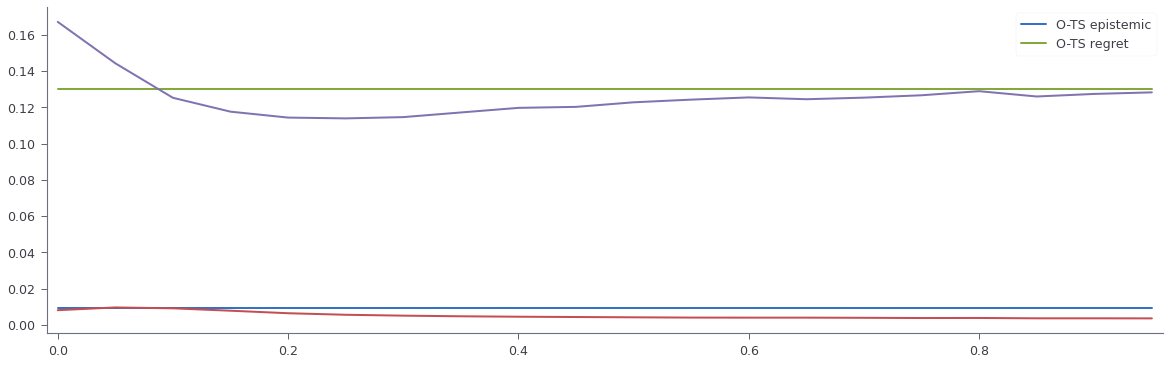

In [49]:
plt.figure(figsize=(20, 6))
lambdas = jnp.arange(0., 1., .05)
lines = plt.plot(lambdas, jnp.array(res)[::2]/1000);
plt.plot(lambdas, jnp.array(res)[1::2]/1000);
plt.legend(iter(lines), ['O-TS epistemic', 'O-TS regret'])

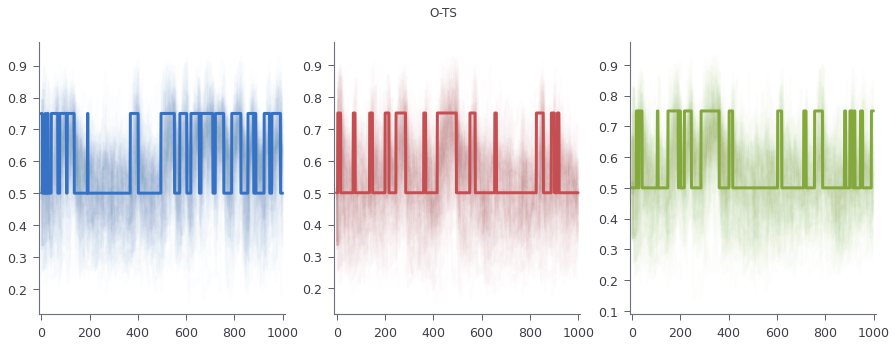

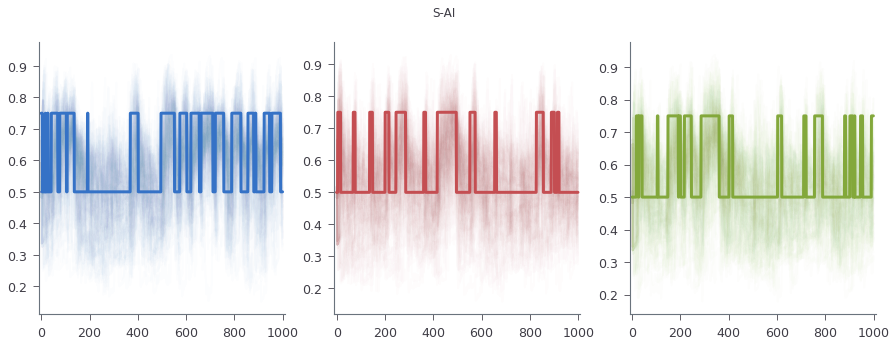

In [14]:
# plot beliefs which were inferred using discretized hidden states
for i, s in enumerate(sequence_states[6:8]):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    post = s['beliefs']
    post_probs = einsum('tnk,lko->tnlo', post.sum(-2), po_ks)
    true_probs = s['probs']

    colours = ['b', 'r', 'g']
    for k in range(K):
        axes[k].plot(post_probs[..., k, k], c=colours[k], alpha=.01)
        axes[k].plot(true_probs[:, k], c=colours[k], lw=3)
    fig.suptitle(labels_states[i])
    plt.show()

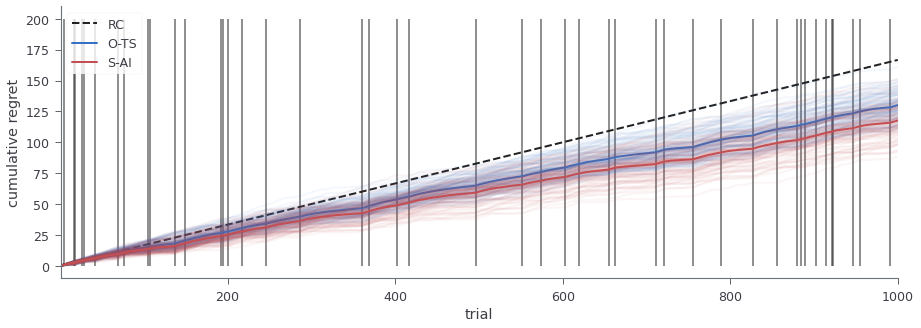

In [16]:
states_probs = [get_hidden_choice_probs(s['choices'], s['probs'], s['choices'].shape[-1]) for s in sequence_states[6:8]]
max_probs = .5 + params['eps']

trials = jnp.arange(1, T + 1)

fig, axes = plt.subplots(1, 1, figsize=(15, 5))

changes = jnp.concatenate([jnp.zeros(1), jnp.abs(jnp.diff(true_probs.argmax(-1)))], -1)
plt.vlines(jnp.nonzero(changes), 0, 200, 'k', alpha=.5)

line_colors = ['b', 'r']

plt.plot(trials, trials * params['eps'] * (K -1)/K, 'k--', label='RC', lw=2)

for i,probs in enumerate(states_probs):
    regret = jnp.cumsum(max_probs - probs, -1).T
    plt.plot(trials, regret, line_colors[i], alpha=.05);
    plt.plot(trials, regret.mean(-1), line_colors[i], label=labels_states[i], lw=2)

plt.xlim(1, T)
# plt.ylim(-10, 180)
plt.xlabel('trial')
plt.ylabel('cumulative regret')
plt.legend(loc=0);

Vertical lines denote change points.

In [9]:
from jax.scipy.special import digamma 
from scipy.special import betaincinv

def parametric_learning(outcomes, choices, beliefs, rho=.0, **kwargs):
    N, K = outcomes.shape
    
    alpha_t = beliefs[..., 0] 
    beta_t = beliefs[..., 1]
    
    select_obs = jnp.eye(K)[choices]
    mu_t = alpha_t/(alpha_t + beta_t)
    _lkl = outcomes * mu_t + (1 - outcomes) * (1 - mu_t)
    lkl = (_lkl * select_obs).sum(-1)
    omega_new = jnp.expand_dims(.5 * rho /(.5 * rho + lkl * (1 - rho)), -1)
    
    alpha_new = (1 - omega_new) * alpha_t + omega_new + select_obs * outcomes
    beta_new = (1 - omega_new) * beta_t + omega_new + select_obs * (1 - outcomes)
    
    return jnp.stack([alpha_new, beta_new], -1)

def parametric_bucb(rng_key, beliefs, **kwargs):
    # bayesian ucb algorithm 
    alpha_t = beliefs[..., 0] 
    beta_t = beliefs[..., 1]
    
    t = kwargs['t']
    rho = kwargs['rho']
    
    bar_alpha = (1 - rho) * alpha_t + rho
    bar_beta = (1 - rho) * beta_t + rho
    
    perc = 1. - 1./(1. + t)
    Q = betaincinv(bar_alpha, bar_beta, perc)
    
    return random.categorical(rng_key, 1e3 * (2 * Q - 1)) # sample choices

def parametric_optimistic(rng_key, beliefs, **kwargs):
    #Optimistic thompson sampling
    alpha_t = beliefs[..., 0] 
    beta_t = beliefs[..., 1]
    omega_t = beliefs[..., :1, 2]
    rho = kwargs['rho']
    
    mu_t = (1 - rho) * alpha_t/(alpha_t + beta_t) + rho/2

    _rng_key, rng_key = random.split(rng_key)
    binary = random.bernoulli(_rng_key, p=1.-rho)
    
    _rng_key, rng_key = random.split(rng_key)
    theta_sample1 = random.beta(_rng_key, alpha_t, beta_t)
    theta_sample2 = random.beta(_rng_key, 1., 1., shape=theta_sample1.shape)
    theta_sample = jnp.where(binary, theta_sample1, theta_sample2)
    
    theta = jnp.where(theta_sample > mu_t, theta_sample, mu_t)
    
    return random.categorical(rng_key, 1e3 * (2 * theta - 1)) # sample choices

def parametric_efe(rng_key, beliefs, lam=1., gamma=1e3, **kwargs):
    # active inference
    alpha_t = beliefs[..., 0] 
    beta_t = beliefs[..., 1]
    
    nu_t = alpha_t + beta_t
    mu_t = alpha_t/nu_t
    
    rho = kwargs['rho']
    tilde_mu = mu_t + rho * (.5 - mu_t)
    
    S_a = - 2 * lam * (1 - rho) * mu_t
    S_a += tilde_mu * jnp.log(tilde_mu) + (1 - tilde_mu) * jnp.log(1 - tilde_mu)
    S_a -= (1 - rho) * (mu_t * digamma(alpha_t) + (1 - mu_t) * digamma(beta_t) + 1/nu_t)
    S_a += (1 - rho) * digamma(nu_t)
    return random.categorical(rng_key, - gamma * (S_a - S_a.mean(-1, keepdims=True))) # sample choices

def parametric_app(rng_key, beliefs, lam=1., gamma=1e3, **kwargs):
    # active inference
    alpha_t = beliefs[..., 0] 
    beta_t = beliefs[..., 1]
    
    nu_t = alpha_t + beta_t
    mu_t = alpha_t/nu_t
    
    S_a = - ( lam * ( 2 * mu_t - 1) + 1/(2 * nu_t) )
    return random.categorical(rng_key, - gamma * (S_a - S_a.mean(-1, keepdims=True))) # sample choices

In [10]:
class SimulatorParametric(object):
    
    def __init__(self, name, process, learning, selection, params, N=10, T=1000, K=10):
        
        self.name = name
        self.N = N  # number of parallel runs
        self.T = T  # number of trials
        self.K = K  # number of arms
        
        self.I = jnp.eye(K)
        
        self.process = process  # generative process
        self.learning = learning  # learning alogrithm 
        self.selection = selection  # action selection algorithm
        
        self.params = params  # parameters of the generative model and process
        
        rho = self.params['rho']
        B = (1 - rho) * jnp.eye(K) + rho * (jnp.ones((K, K)) - jnp.eye(K))/(K-1)
        self.params['B'] = B
        self.params['K'] = K
        
    def scan(self, func, carry, iterator):
        if self.name == 'B-UCB':
            return self._scan(func, carry, iterator)
        else:
            _, res = lax.scan(func, carry, iterator)
            return res
        
    def _scan(self, func, carry, iterator):
        sequence = []
        for n in iterator:
            carry, res = func(carry, n)
            sequence.append(res)
        
        final = defaultdict(lambda: [])
        for seq in sequence:
            for key in seq.keys():
                final[key].append(seq[key])
        
        for key in final.keys():
            final[key] = jnp.stack(final[key], 0)
        
        return final
        
    def run(self, prior, rng_key=random.PRNGKey(0)):
        def sim_fn(carry, t):
            rng_key, states, prior, regret, epist_reg = carry

            rng_key, _rng_key = random.split(rng_key)
            choices = self.selection(_rng_key, prior, t=t, **self.params)
            
            regret += self.params['eps'] * ~(choices == states)

            rng_key, _rng_key = random.split(rng_key)
            outcomes, states = self.process(_rng_key, t, choices, states, **self.params)
            
            posterior = self.learning(outcomes, choices, prior, **self.params)
            
            alpha_t = posterior[..., 0] 
            beta_t = posterior[..., 1]
            
            rho = self.params['rho']
            nu_t = alpha_t + beta_t
            mu_t = alpha_t/nu_t
    
            tilde_mu = mu_t + rho * (.5 - mu_t)
            EIG = tilde_mu * jnp.log(tilde_mu) + (1 - tilde_mu) * jnp.log(1 - tilde_mu)
            EIG -= (1 - rho) * (mu_t * digamma(alpha_t) + (1 - mu_t) * digamma(beta_t) + 1/nu_t)
            EIG += (1 - rho) * digamma(nu_t)
            
            epist_reg += jnp.max(EIG, -1) - EIG[jnp.arange(0, self.N, 1), choices]
            
            return (rng_key, states, posterior, regret, epist_reg), {'regret': regret, 'epistemic': epist_reg}
        
        rng_key, _rng_key = random.split(rng_key)
        states = random.categorical(_rng_key, jnp.zeros(K), shape=(N,))
        result = self.scan(sim_fn, (rng_key, states, prior, jnp.zeros(self.N), jnp.zeros(self.N)), jnp.arange(self.T))
    
        return result

In [36]:
K = 20
N = 1000
T = 1000
rng_key = random.PRNGKey(12345)

labels_parametric = ['G-AI', 'A-AI']
regret_all = {'G-AI': defaultdict(lambda: {}), 'A-AI': defaultdict(lambda: {})}
for selection, label in zip([parametric_efe, parametric_app], labels_parametric):
    for lam in jnp.arange(0, 200, 20):
        regret_all[label][lam] = defaultdict(lambda: {})
        for R in [1, 2, 4]:
            regret_all[label][lam][R] = defaultdict(lambda: {})
            for eps in [10, 25, 40]:
                params = {
                    'lam': lam/100.,
                    'eps': eps/100.,
                    'rho': R/100.
                }

                prior = jnp.stack([jnp.ones((N, K)), jnp.ones((N, K))], -1)
                sim = SimulatorParametric(label, process, parametric_learning, selection, params, N=N, T=T, K=K)

                rng_key, _rng_key = random.split(rng_key)
                regret_all[label][lam][R][eps] = sim.run(prior, rng_key=_rng_key)

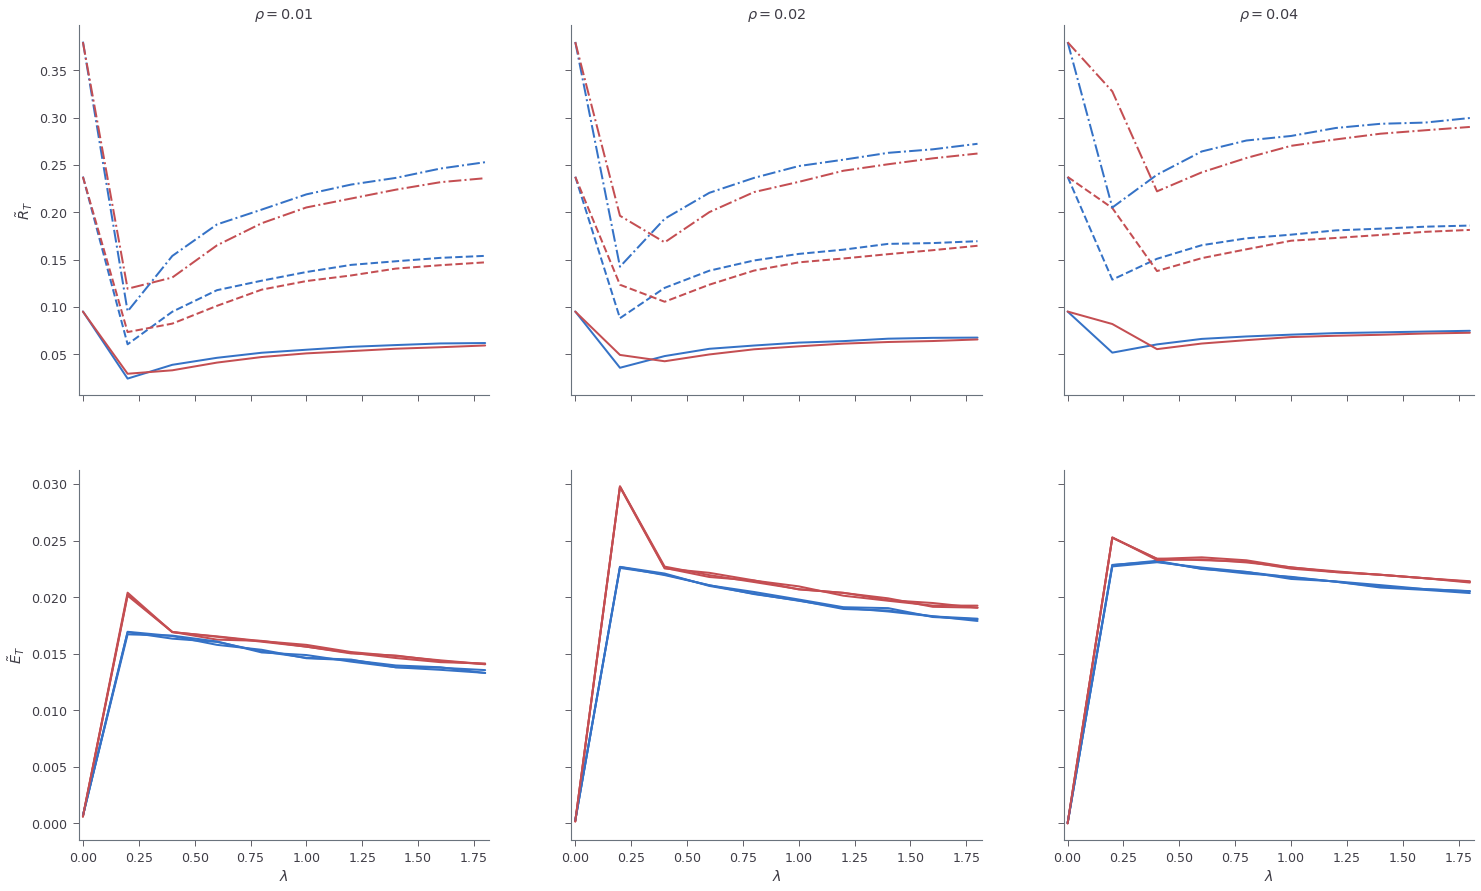

In [37]:
from scipy.stats import norm
fig, axes = plt.subplots(2, 3, figsize=(25, 15), sharex=True, sharey='row')
colors = ['b', 'r']
linestyle = ['-', '--', '-.']
lambdas = jnp.arange(0, 200, 20)
times = jnp.arange(1, T+1, 1)[:, None]
for i, R in enumerate([1, 2, 4]):
    for e, eps in enumerate([10, 25, 40]):
        regret_rate = {'G-AI': [], 'A-AI': []}
        epistemic_rate = {'G-AI': [], 'A-AI': []}
        for lam in lambdas:
            for label in ['G-AI', 'A-AI']:
                _, res = regret_all[label][lam][R][eps]
                regret_rate[label].append([(res['regret']/times).mean(-1)[-1], (res['regret']/times).std(-1)[-1]/jnp.sqrt(N)])
                epistemic_rate[label].append((res['epistemic']/times).mean(-1)[-1])

        for n, label in enumerate(['G-AI', 'A-AI']):
            mu = jnp.array(regret_rate[label])[:, 0]
            std = jnp.array(regret_rate[label])[:, 1]
            conf_int = norm.interval(.95, mu, std)
            axes[0, i].plot(lambdas/100, mu, color=colors[n], lw=2, linestyle=linestyle[e])
        
        axes[0, i].set_title(r'$\rho={}$'.format(R/100))

        axes[1, i].plot(lambdas/100, epistemic_rate['G-AI'], 'b', lw=2)
        axes[1, i].plot(lambdas/100, epistemic_rate['A-AI'], 'r', lw=2)
        axes[1, i].set_xlabel(r'$\lambda$')

        axes[0, 0].set_ylabel(r'$\tilde{R}_T$')
        axes[1, 0].set_ylabel(r'$\tilde{E}_T$')

In [12]:
N = 1000
T = 5000
rng_key = random.PRNGKey(1234)

sequences = defaultdict(lambda: {})
for K in [10, 20, 40]:
    sequences[K] = defaultdict(lambda: [])
    for R in [1, 2, 4]:
        labels_parametric = ['B-UCB', 'O-TS', 'A-AI']

        params = {
            'lam': .5,
            'eps': .25,
            'rho': R/100.,
        }

        prior = jnp.stack([jnp.ones((N, K)), jnp.ones((N, K))], -1)
        for selection, label in zip([parametric_bucb, parametric_optimistic, parametric_app], labels_parametric):
            rng_key, _rng_key = random.split(rng_key)
            sim = SimulatorParametric(label, process, parametric_learning, selection, params, N=N, T=T, K=K)
            sequences[K][R].append(sim.run(prior, rng_key=rng_key))

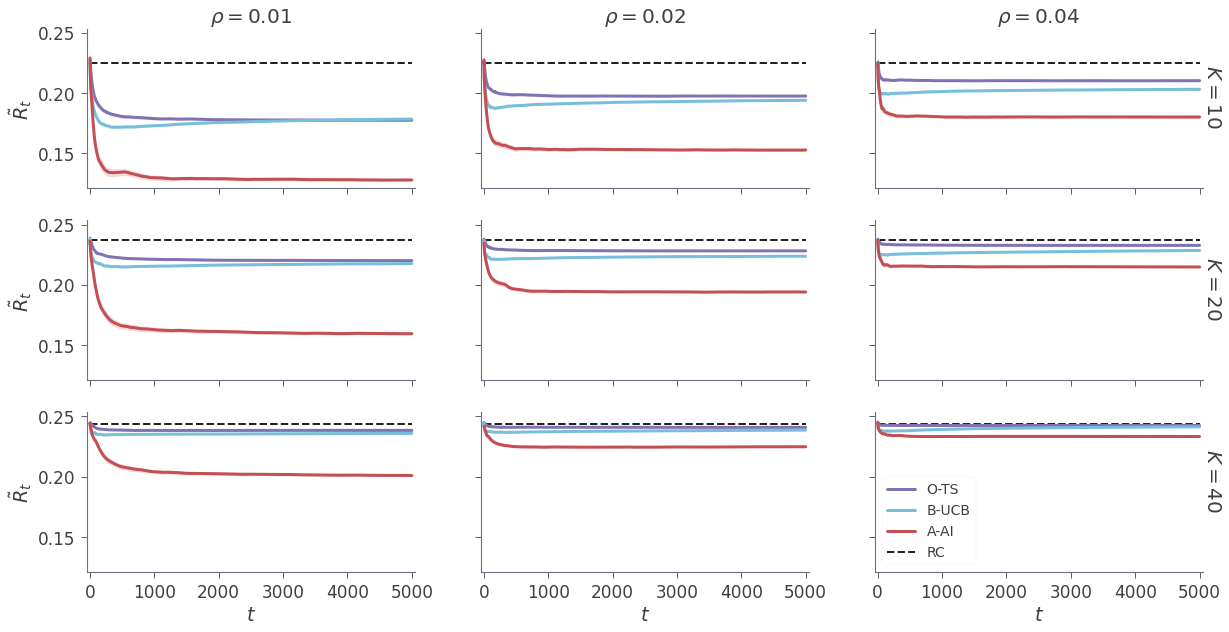

In [42]:
from scipy.stats import t
eps = .25
trials = jnp.arange(1, T+1)
fig, axes = plt.subplots(3, 3, figsize=(20, 10), sharex=True, sharey=True)
labels_parametric = ['B-UCB', 'O-TS', 'A-AI']

t_bounds = t.interval(0.95, N - 1)

for i, K in enumerate(sequences.keys()):
    for j, R in enumerate(sequences[K].keys()):
        line_colors = ['c', 'm', 'r']
        for l in [1, 0, 2]:
            regret = sequences[K][R][l]['regret']
            mean = jnp.mean(regret/trials[:, None], -1)
            std = jnp.std(regret/trials[:, None], -1, ddof=1)
            ci = [mean + critval * std/jnp.sqrt(N) for critval in t_bounds]
            axes[i, j].fill_between(trials, ci[1], y2=ci[0], color=line_colors[l], alpha=.2)
            axes[i, j].plot(trials, mean, line_colors[l], label=labels_parametric[l], lw=3)
        axes[i, j].hlines(eps * (K - 1)/K, trials[0], trials[-1], color='k', linestyle='--', label='RC')
        if i == 2:
            axes[i, j].set_xlabel(r'$t$')
        if i == 0:
            axes[i, j].set_title(r'$\rho={}$'.format(R/100.), fontsize=20)
    axes[i, -1].text(1., .4, r'$K={}$'.format(K), transform=axes[i, -1].transAxes, fontsize=20, rotation=-90)
    axes[i, 0].set_ylabel(r'$\tilde{R}_t$')

plt.legend(fontsize=14);
fig.savefig('Fig3.pdf', transparent=True, bbox_inches='tight', dpi=300)

In [13]:
N = 1000
T = 5000
rng_key = random.PRNGKey(123456)
K = 20

sequences2 = defaultdict(lambda: {})
for eps in [10, 25, 40]:
    sequences2[eps] = defaultdict(lambda: [])
    for R in [1, 2, 4]:
        labels_parametric = ['O-TS', 'B-UCB', 'A-AI']

        params = {
            'lam': .5,
            'eps': eps/100,
            'rho': R/100,
        }

        prior = jnp.stack([jnp.ones((N, K)), jnp.ones((N, K))], -1)
        for selection, label in zip([parametric_optimistic, parametric_bucb, parametric_app], labels_parametric):
            rng_key, _rng_key = random.split(rng_key)
            sim = SimulatorParametric(label, process, parametric_learning, selection, params, N=N, T=T, K=K)
            sequences2[eps][R].append(sim.run(prior, rng_key=_rng_key))

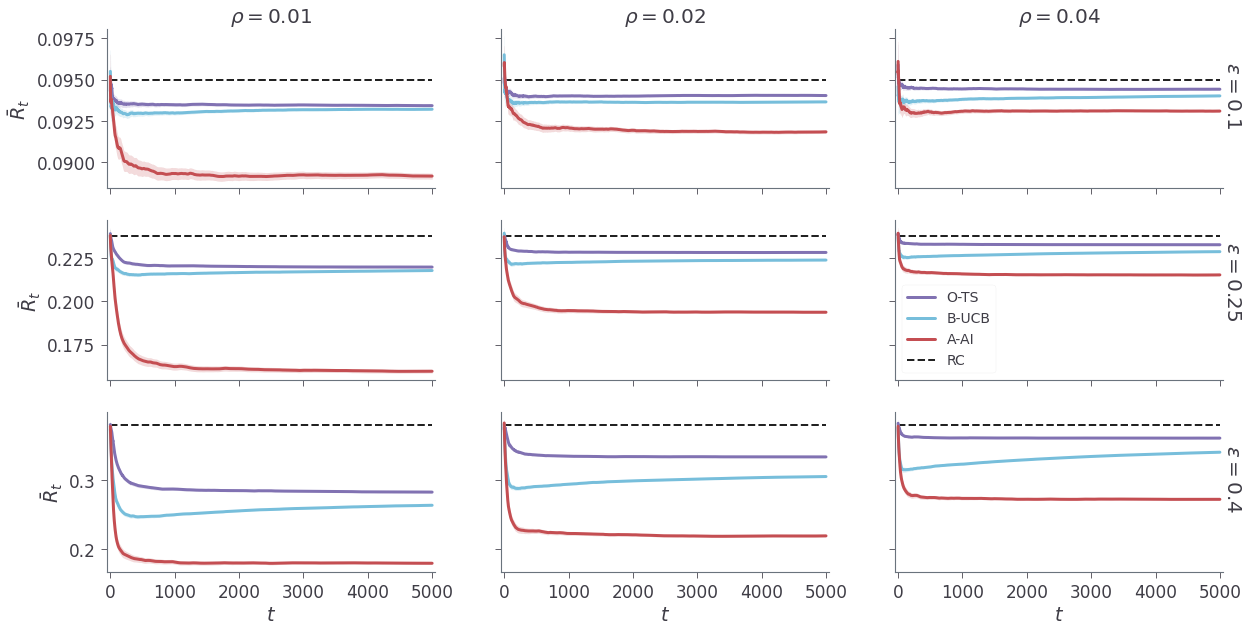

In [38]:
from scipy.stats import t
K = 20
trials = jnp.arange(1, T+1)
fig, axes = plt.subplots(3, 3, figsize=(20, 10), sharex=True, sharey='row')
labels_parametric = ['O-TS', 'B-UCB', 'A-AI']

t_bounds = t.interval(0.95, N - 1)

for i, eps in enumerate(sequences2.keys()):
    for j, R in enumerate(sequences2[eps].keys()):
        line_colors = ['m', 'c', 'r']
        for l in range(3):
            regret = sequences2[eps][R][l]['regret']
            mean = jnp.mean(regret/trials[:, None], -1)
            std = jnp.std(regret/trials[:, None], -1, ddof=1)
            ci = [mean + critval * std/jnp.sqrt(N) for critval in t_bounds]
            axes[i, j].fill_between(trials, ci[1], y2=ci[0], color=line_colors[l], alpha=.2)
            axes[i, j].plot(trials, mean, line_colors[l], label=labels_parametric[l], lw=3)
        axes[i, j].hlines(eps/100 * (K - 1)/K, trials[0], trials[-1], color='k', linestyle='--', label='RC')
        if i == 2:
            axes[i, j].set_xlabel(r'$t$')
        if i == 0:
            axes[i, j].set_title(r'$\rho={}$'.format(R/100.), fontsize=20)
    
    axes[i, -1].text(1., .4, r'$\epsilon={}$'.format(eps/100), transform=axes[i, -1].transAxes, fontsize=20, rotation=-90)
    axes[i, 0].set_ylabel(r'$\bar{R}_t$')

axes[1, -1].legend(fontsize=14);
fig.savefig('Fig4.pdf', transparent=True, bbox_inches='tight', dpi=300)

In [29]:
from environment import generative_process_swtch2

class SimulatorParametric2(object):
    # Simulate switching multi armed bandit with non-stationary difficulty
    
    def __init__(self, name, learning, selection, params, N=10, T=1000, K=10):
        
        self.name = name
        self.N = N  # number of parallel runs
        self.T = T  # number of trials
        self.K = K  # number of arms
        
        self.I = jnp.eye(K)
        
        rho = params['rho']
        log_pj_j = jnp.log(jnp.array([[1 - rho, rho], [1., 0.]]))
        self.process = lambda *args, **kwargs: generative_process_swtch2(*args, log_pj_j, **kwargs) # generative process        
        self.learning = learning  # learning alogrithm 
        self.selection = selection  # action selection algorithm
        
        self.params = params  # parameters of the generative model and process
        self.params['K'] = K
        
    def scan(self, func, carry, iterator):
        if self.name == 'B-UCB':
            return self._scan(func, carry, iterator)
        else:
            _, res = lax.scan(func, carry, iterator)
            return res
        
    def _scan(self, func, carry, iterator):
        sequence = []
        for n in iterator:
            carry, res = func(carry, n)
            sequence.append(res)
        
        final = defaultdict(lambda: [])
        for seq in sequence:
            for key in seq.keys():
                final[key].append(seq[key])
        
        for key in final.keys():
            final[key] = jnp.stack(final[key], 0)
        
        return final
        
    def run(self, prior, seed=0):
        def sim_fn(carry, t):
            rng_key, states, prior, regret, epist_reg = carry

            rng_key, _rng_key = random.split(rng_key)
            choices = self.selection(_rng_key, prior, t=t, **self.params)
            
            regret += states[0].max() - states[0][jnp.arange(N), choices]

            rng_key, _rng_key = random.split(rng_key)
            outcomes, states = self.process(t, choices, states, _rng_key, **self.params)
            
            posterior = self.learning(outcomes, choices, prior, **self.params)
            
            alpha_t = posterior[..., 0] 
            beta_t = posterior[..., 1]
            
            rho = self.params['rho']
            nu_t = alpha_t + beta_t
            mu_t = alpha_t/nu_t
    
            tilde_mu = mu_t + rho * (.5 - mu_t)
            EIG = tilde_mu * jnp.log(tilde_mu) + (1 - tilde_mu) * jnp.log(1 - tilde_mu)
            EIG -= (1 - rho) * (mu_t * digamma(alpha_t) + (1 - mu_t) * digamma(beta_t) + 1/nu_t)
            EIG += (1 - rho) * digamma(nu_t)
            
            epist_reg += jnp.max(EIG, -1) - EIG[jnp.arange(0, self.N, 1), choices]
            
            return (rng_key, states, posterior, regret, epist_reg), {'regret': regret, 'epistemic': epist_reg}

        rng_key = random.PRNGKey(seed)
        rng_key, _rng_key = random.split(rng_key)
        probs = random.uniform(_rng_key, shape=(N, K))
        states = [probs, jnp.zeros(N, dtype=jnp.int32)]

        result = self.scan(sim_fn, (rng_key, states, prior, jnp.zeros(self.N), jnp.zeros(self.N)), jnp.arange(self.T))
    
        return result

In [26]:
def random_choices(rng_key, beliefs, **kwargs):
    # active inference
    N, K = beliefs.shape[:-1]
    return random.categorical(rng_key, jnp.zeros((N, K))) # sample choices    

In [30]:
N = 1000
T = 5000
seed = 1234567
labels_parametric = ['O-TS', 'B-UCB', 'A-AI', 'RC']

sequences3 = defaultdict(lambda: {})
for K in [10, 20, 40]:
    sequences3[K] = defaultdict(lambda: [])
    for R in [1, 2, 4]:

        params = {
            'lam': .5,
            'rho': R/100,
        }

        prior = jnp.stack([jnp.ones((N, K)), jnp.ones((N, K))], -1)
        for i, selection in enumerate([parametric_optimistic, parametric_bucb, parametric_app, random_choices]):
            sim = SimulatorParametric2(labels_parametric[i], parametric_learning, selection, params, N=N, T=T, K=K)
            sequences3[K][R].append(sim.run(prior, seed=seed))

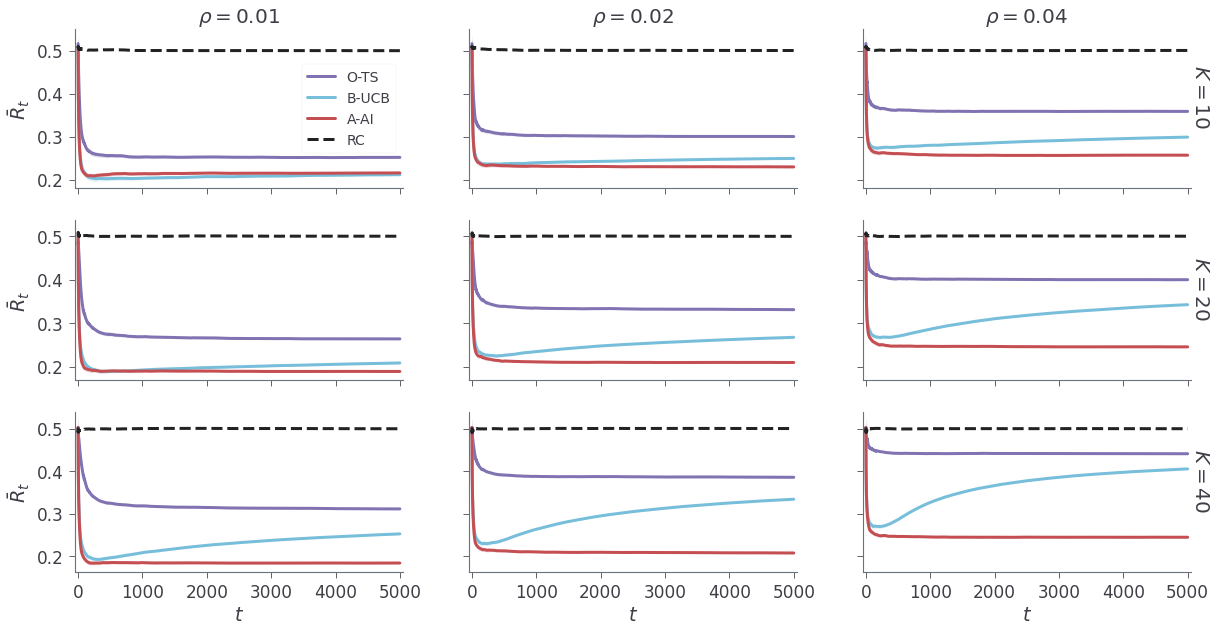

In [41]:
trials = jnp.arange(1, T+1)
fig, axes = plt.subplots(3, 3, figsize=(20, 10), sharex=True, sharey='row')
labels_parametric = ['O-TS', 'B-UCB', 'A-AI', 'RC']

for i, K in enumerate(sequences3.keys()):
    for j, R in enumerate(sequences3[K].keys()):
        line_colors = ['m', 'c', 'r', 'k--']
        for l in range(4):
            regret = sequences3[K][R][l]['regret']
            mean = jnp.mean(regret/trials[:, None], -1)
            std = jnp.std(regret/trials[:, None], -1, ddof=1)
            ci = [mean + critval * std/jnp.sqrt(N) for critval in t_bounds]
            if l < 3:
                axes[i, j].fill_between(trials, ci[1], y2=ci[0], color=line_colors[l], alpha=.2)
            axes[i, j].plot(trials, mean, line_colors[l], label=labels_parametric[l], lw=3)
            
        if i == 2:
            axes[i, j].set_xlabel(r'$t$')
        if i == 0:
            axes[i, j].set_title(r'$\rho={}$'.format(R/100.), fontsize=20)
    axes[i, -1].text(1., .4, r'$K={}$'.format(K), transform=axes[i, -1].transAxes, fontsize=20, rotation=-90)
    axes[i, 0].set_ylabel(r'$\bar{R}_t$')

axes[0,0].legend(fontsize=14);
fig.savefig('Fig5.pdf', transparent=True, bbox_inches='tight', dpi=300)